
# Comparative performance of shrimp models

## Notebook Summary

This notebook is developed from the New Atlantis XGBoost Template. We run several models for total shrimp mass and compare their relative performances.

# Models

### Baseline model

We started with the simple model which simply returns the mean of the training data. This gives a baseline mean squared error to evaluate how much each model improves upon this baseline.

MSE = 2.4884

### Models without imputation

The first class of models we considered are those which are able to handle missing data without needing to impute values.

 - XGBoost (eXtreme Gradient Boosting) is an advanced implementation of gradient boosting machines which handles missing data automatically. (MSE = 1.6099)

- Histogram Gradient Boosting is a modified Gradient Boosting in which continuous features are divided into discrete bins (histograms), reducing the number of unique feature values. Like XGBoost, this model can handle missingness effectively. **(MSE = 1.3901)**



### Models with imputation

After comparing the performance of these models and performing feature selection, we then imputed the missing values for features and ran a number of other models

- LinearRegressor (MSE = 2.1474)
- SVMRegressor (MSE = 2.0916)
- KNeighborsRegressor (MSE = 1.9059)
- RandomForestRegressor (MSE = 1.5493)
- AdaBoostRegressor (MSE = 3.3975)
- GradientBoostingRegressor (MSE = 1.6334)
- HistGradientBoostingRegressor with imputation (MSE = 1.4342)

## Model tuning

Given that the best performing model was HistGradBoostingRegressor, we tuned the parameters for this model and attempted to rescale the features to improve performance. The default parameters ended up performed the best and scaling did not meaningfully improve the performance.

## SHAP plots

Finally, we use Shapely to understand the most predictive features for the best performing model HistGradBoostingRegressor model.


In [1]:
# Install necessary libraries
!pip install shap

# Import necessary libraries
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the dataset into a Pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/SHRIMP_constant_gear.csv')

In [4]:


# Preprocess the data
def preprocess_data(df):


    # Drop irrelevant columns
    df = df.drop(['MILITARY_TIME_STR', 'TEMP_SSURF','HAULVALUE', 'TIME_MIL'],  axis=1)  # Add this line
    return df

# Preprocess and display the dataframe
df = preprocess_data(df)
df.head()

,STATIONID,DEPTH_EMAX,TEMPSURF,TEMPMID,SALSURF,SALMID,SALMAX,OXYSURF,OXYMID,OXYMAX,...,CNT_PF,CNT_WM,CNT_WF,GEAR_SIZE,GEAR_TYPE,MESH_SIZE,MIN_FISH,TOTAL_SHRIMP_COUNT,TOTAL_SHRIMP_WEIGHT,MINUTES_SINCE_MIDNIGHT
0,504,14.0,24.98,22.41,29.65,34.76,35.01,4.6,4.4,4.1,...,0.0,0.0,0.0,40.0,ST,1.63,15.0,2.0,0.030,523
1,505,13.0,25.96,24.79,21.12,30.96,34.57,7.6,5.3,0.8,...,0.0,0.0,0.0,40.0,ST,1.63,18.0,1.0,0.005,670
2,508,34.0,27.72,23.02,27.95,36.02,36.14,6.6,4.7,4.9,...,1.0,0.0,0.0,40.0,ST,1.63,42.0,2.0,0.020,982
3,509,27.0,26.93,23.30,25.23,35.38,36.14,6.9,6.5,5.0,...,1.0,0.0,0.0,40.0,ST,1.63,10.0,1.0,0.010,1185
4,510,24.0,26.53,23.50,25.46,34.89,36.11,6.8,6.8,4.6,...,50.0,0.0,0.0,40.0,ST,1.63,44.0,107.0,3.006,1228


In [5]:
from sklearn.model_selection import train_test_split

def split_data(df):
  # These features give the best performance overall, but can be changed if needed
  X= df[['DEPTH_EMAX',
              'TEMPSURF',
              'TEMPMID',
              'SALSURF',
              'SALMAX',
              'OXYSURF',
              'OXYMID',
              'OXYMAX',
              'CHLORSURF',
              'CHLORMID',
              'CHLORMAX',
              'TEMP_BOT',
              'DECSLAT',
              'DECSLON',
              'YEAR',
              'DAYOFYEAR',
              'MINUTES_SINCE_MIDNIGHT']]
  y = df['TOTAL_SHRIMP_WEIGHT']

  # Split into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=216)
  return X_train, X_test, y_train, y_test

# Split the data
X_train, X_test, y_train, y_test = split_data(df)

# Create a copy of X_train and insert y_train as a new column
X_tt = X_train.copy()
X_tt["TOTAL_SHRIMP_WEIGHT"] = y_train

# Now split the combined data again
X_tt, X_val, y_tt, y_val = split_data(X_tt)

In [7]:
# prompt: Find the mean squared error of the baseline model which just returns the mean of the training set

# Calculate the mean of the training target values
y_tt_mean = y_tt.mean()

# Create an array of predicted values, all equal to the mean
y_pred_baseline = np.full_like(y_val, y_tt_mean)

# Calculate the mean squared error for the baseline model
mse_baseline = mean_squared_error(y_val, y_pred_baseline)
print(f'baseline Mean Squared Error: {mse_baseline}')

baseline Mean Squared Error: 2.4884055228466515


In [6]:
models = {
    'xgb': xgb.XGBRegressor(
    max_depth=3,  # Maximum depth of a tree
    learning_rate=0.1,  # Learning rate
    n_estimators=100,  # Number of trees
    subsample=0.8,  # Subsample ratio of the training instances
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    gamma=0,  # Minimum loss reduction required to make a further partition
    min_child_weight=1  # Minimum sum of instance weight needed in a child
),
    'hgb':HistGradientBoostingRegressor(),
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_tt, y_tt)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    print(f"{name} Mean Squared Error: {mse}")




xgb Mean Squared Error: 1.6098723447861616
hgb Mean Squared Error: 1.3901438241851727


## Performance evaluation

Both HistGradBoostingRegressor and XGBoost outperformed the baseline model, but HistGradBoostingRegressor outperformed XGBoost (and this remained true for all choices of features that we encountered). Therefore, we will focus on HGB going forward

## Hyperparameter Tuning with Grid Search

We now perform hyperparameter tuning for the  HGB model, to see if we can improve the performance.


In [ ]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 150],
    'l2_regularization': [0.0, 0.1, 0.2]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=modelhgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_tt, y_tt)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Extract the best parameters from the grid search
best_params = grid_search.best_params_

#Create a model with the best parameters
best_hgb_model = HistGradientBoostingRegressor(**best_params) # Use HistGradientBoostingRegressor from the imported module

# Train the best model
best_hgb_model.fit(X_tt, y_tt)

# Make predictions on the test set
y_pred_best = best_hgb_model.predict(X_val)

# Evaluate the best model
mse_hgb_best = mean_squared_error(y_val, y_pred_best)
print(f"Mean Squared Error (Best Model): {mse_hgb_best}")

Best Parameters: {'l2_regularization': 0.0, 'learning_rate': 0.1, 'max_iter': 100}
Best Score: 1.573984345023701
Mean Squared Error (Best Model): 1.3901438241851727


# Imputation and Scaling


We now create a pipeline which imputes the missing features and scales the features. From this, we are able to run a larger class of models.

In [9]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

# Create a pipeline with KNNImputer and StandardScaler
pipeline = Pipeline([
   ('imputer', KNNImputer(n_neighbors=10, weights = 'distance')),
    ('scaler', RobustScaler())
])

# Fit and transform the training data
X_tt_transformed = pipeline.fit_transform(X_tt)

# Transform the test data
X_val_transformed = pipeline.transform(X_val)

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor


models_imp = {
    'lr': LinearRegression(),
    'svr': SVR(),
    'knr': KNeighborsRegressor(n_neighbors=10),
    'rf': RandomForestRegressor(),
    'ab': AdaBoostRegressor(),
    'gb': GradientBoostingRegressor(),
    'hgb_imp': HistGradientBoostingRegressor()
}

mses_imp = {}
for name, model in models_imp.items():
    model.fit(X_tt_transformed,y_tt)
    mses_imp[name] = mean_squared_error(y_val, model.predict(X_val_transformed))

print(mses_imp)


{'lr': 2.147440530800411, 'svr': 2.0916030310588893, 'knr': 1.9058636044089918, 'rf': 1.5492727929588832, 'ab': 3.397468744284278, 'gb': 1.633447030834619, 'hgb_imp': 1.434155167092104}


None of the imputed models outperformed HGB. However, as a final check we will scale the features and run HGB without imputation, to see if scaling improves performance.

In [11]:
# Create a pipeline with Scaling along
scalingpipeline = Pipeline([
   #('imputer', KNNImputer(n_neighbors=10, weights = 'distance')),
    ('scaler', RobustScaler())
])

In [14]:
# Fit and transform the training data
X_tt_scaled = scalingpipeline.fit_transform(X_tt)

# Transform the test data
X_val_scaled = scalingpipeline.transform(X_val)

In [15]:
models_scaled = {
    'xgb': xgb.XGBRegressor(
    max_depth=3,  # Maximum depth of a tree
    learning_rate=0.1,  # Learning rate
    n_estimators=100,  # Number of trees
    subsample=0.8,  # Subsample ratio of the training instances
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    gamma=0,  # Minimum loss reduction required to make a further partition
    min_child_weight=1  # Minimum sum of instance weight needed in a child
),
    'hgb':HistGradientBoostingRegressor(),
}

# Train and evaluate each model
for name, model in models_scaled.items():
    model.fit(X_tt_scaled, y_tt)
    y_pred = model.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred)
    print(f"{name} Mean Squared Error: {mse}")

xgb Mean Squared Error: 1.6098723447861616
hgb Mean Squared Error: 1.3900301032043412


The performance here is nearly identical to the unscaled version, but we can again try parameter tuning.

In [16]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 150],
    'l2_regularization': [0.0, 0.1, 0.2]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=modelhgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_tt_scaled, y_tt)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Extract the best parameters from the grid search
best_params = grid_search.best_params_

#Create a model with the best parameters
best_hgb_model = HistGradientBoostingRegressor(**best_params) # Use HistGradientBoostingRegressor from the imported module

# Train the best model
best_hgb_model.fit(X_tt_scaled, y_tt)

# Make predictions on the test set
y_pred_best = best_hgb_model.predict(X_val_scaled)

# Evaluate the best model
mse_hgb_best = mean_squared_error(y_val, y_pred_best)
print(f"Mean Squared Error (Best Model): {mse_hgb_best}")

Best Parameters: {'l2_regularization': 0.0, 'learning_rate': 0.1, 'max_iter': 100}
Best Score: 1.573991563380869
Mean Squared Error (Best Model): 1.3900301032043412


## Understanding the HGB predictions

In this section, we use SHAP to understand the predictions of the HGB model.

![SHAP Logo](https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_logo.png)
## (SHapley Additive exPlanations)

SHAP is a Python library for interpreting machine learning models and explaining their predictions. It's based on game theory and provides a unified approach to explaining the output of any machine learning model.

### Key Features:

- **Model Agnostic**: Works with any machine learning model
- **Local and Global Explanations**: Provides both instance-level and model-level interpretations
- **Visualization Tools**: Offers various plots for intuitive understanding of model behavior

### Usage:

SHAP can be used to:
1. Explain individual predictions
2. Understand global model behavior
3. Identify feature importance
4. Visualize feature interactions

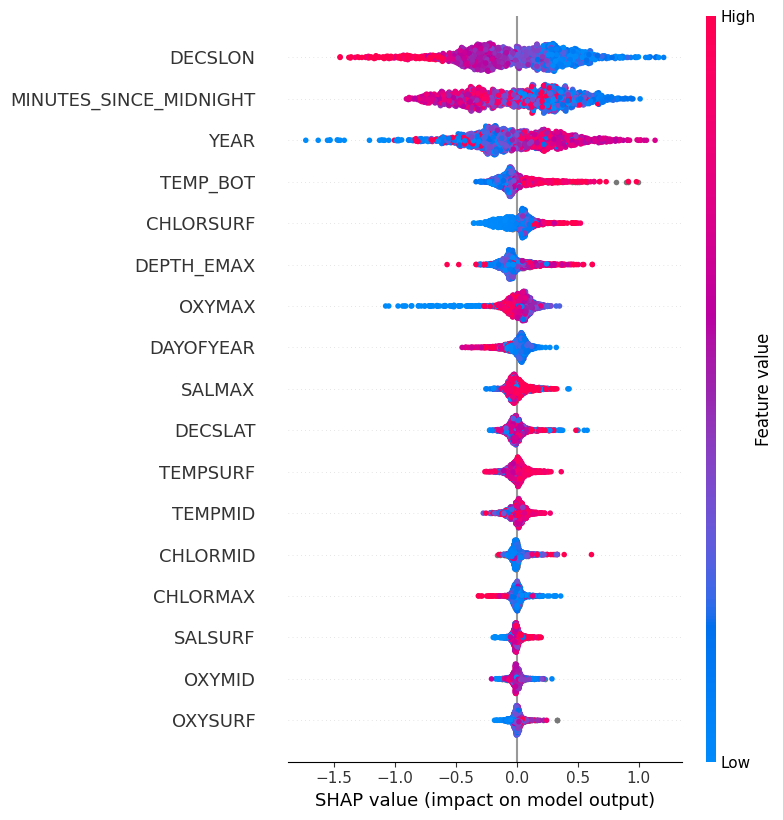

In [8]:
#Fitting the hgb model
modelhgb = HistGradientBoostingRegressor()
modelhgb.fit(X_tt, y_tt)

#Explain the HGBoost model predictions with SHAP
explainerhgb = shap.TreeExplainer(modelhgb)
shap_valueshgb = explainerhgb.shap_values(X_test)

# Visualize the HGB prediction's explanation
shap.initjs()
shap.force_plot(explainerhgb.expected_value, shap_valueshgb[0,:], X_test.iloc[0,:])

# Summarize the HGB effects of all the features
shap.summary_plot(shap_valueshgb, X_test)